In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *

from annotation_utilities import *
from registration_utilities import *
from conversion import *

Setting environment for Gordon


No vtk


In [16]:
stack = 'MD585'

In [17]:
filenames_to_sections = {f: s for s, f in metadata_cache['sections_to_filenames'][stack].iteritems() 
                         if not is_invalid(f)}

In [18]:
contour_df, _ = DataManager.load_annotation_v3(stack=stack)
contour_df = convert_annotation_v3_original_to_aligned(contour_df, stack=stack)

'No object named structures in the file'


Annotation has no structures.


In [6]:
# Treat section as a single z value or a whole voxel slice.

In [5]:
downscale = 32

In [11]:
def contours_2d_to_3d(matched_contours, convert_to='aligned'):
    """
    Convert matched annotation dataframe entries to contours as a list of 3d array.
    """
    
    contours_3d = []
    
    for cnt_id, cnt in matched_contours.iterrows():

        fn = cnt['filename']
        if is_invalid(fn=fn, stack=stack) or not isinstance(fn, str): # Sometimes fn is nan, don't know why.
            continue
        
        section = filenames_to_sections[fn]
        zl, zh = DataManager.convert_section_to_z(stack=stack, sec=section, downsample=downscale, first_sec=1)
        z = int(np.round((zl + zh)/2))
        n = len(cnt['vertices'])
        vertices_on_aligned_3d = np.c_[cnt['vertices']/downscale, z*np.ones((n,))]
        contours_3d.append(vertices_on_aligned_3d)
        
    return contours_3d

In [12]:
contours_grouped_by_name = {}

for name_u in singular_structures:
    print name_u
    
    matched_contours = contour_df[(contour_df['name'] == name_u)]
    if len(matched_contours) == 0:
        continue
    contours_3d = contours_2d_to_3d(matched_contours)
    contours_grouped_by_name[name_u] = contours_3d

for name_u in paired_structures:
    print name_u

    matched_contours = contour_df[(contour_df['name'] == name_u) & (contour_df['side'] == 'L')]
    if len(matched_contours) == 0:
        continue
    contours_3d = contours_2d_to_3d(matched_contours)
    contours_grouped_by_name[convert_to_left_name(name_u)] = contours_3d
    
    matched_contours = contour_df[(contour_df['name'] == name_u) & (contour_df['side'] == 'R')]
    if len(matched_contours) == 0:
        continue
    contours_3d = contours_2d_to_3d(matched_contours)
    contours_grouped_by_name[convert_to_right_name(name_u)] = contours_3d

AP
12N
RtTg
sp5
outerContour
SC
IC
5N
6N
7N
7n
Amb
LC
LRt
Pn
Tz
VLL
RMC
SNC
SNR
3N
4N
Sp5I
Sp5O
Sp5C
PBG
10N
VCA
VCP
DC


In [13]:
structure_to_label = {structure: i + 1 for i, structure in enumerate(sorted(contours_grouped_by_name.keys()))}
contours_grouped_by_label = {structure_to_label[name]: contours for name, contours in contours_grouped_by_name.iteritems()}

In [14]:
volume, bbox = contours_to_volume(contours_grouped_by_label=contours_grouped_by_label, 
                                                             interpolation_direction='z', return_shell=False)

print bbox

(594, 1028, 125, 485, 112, 474)


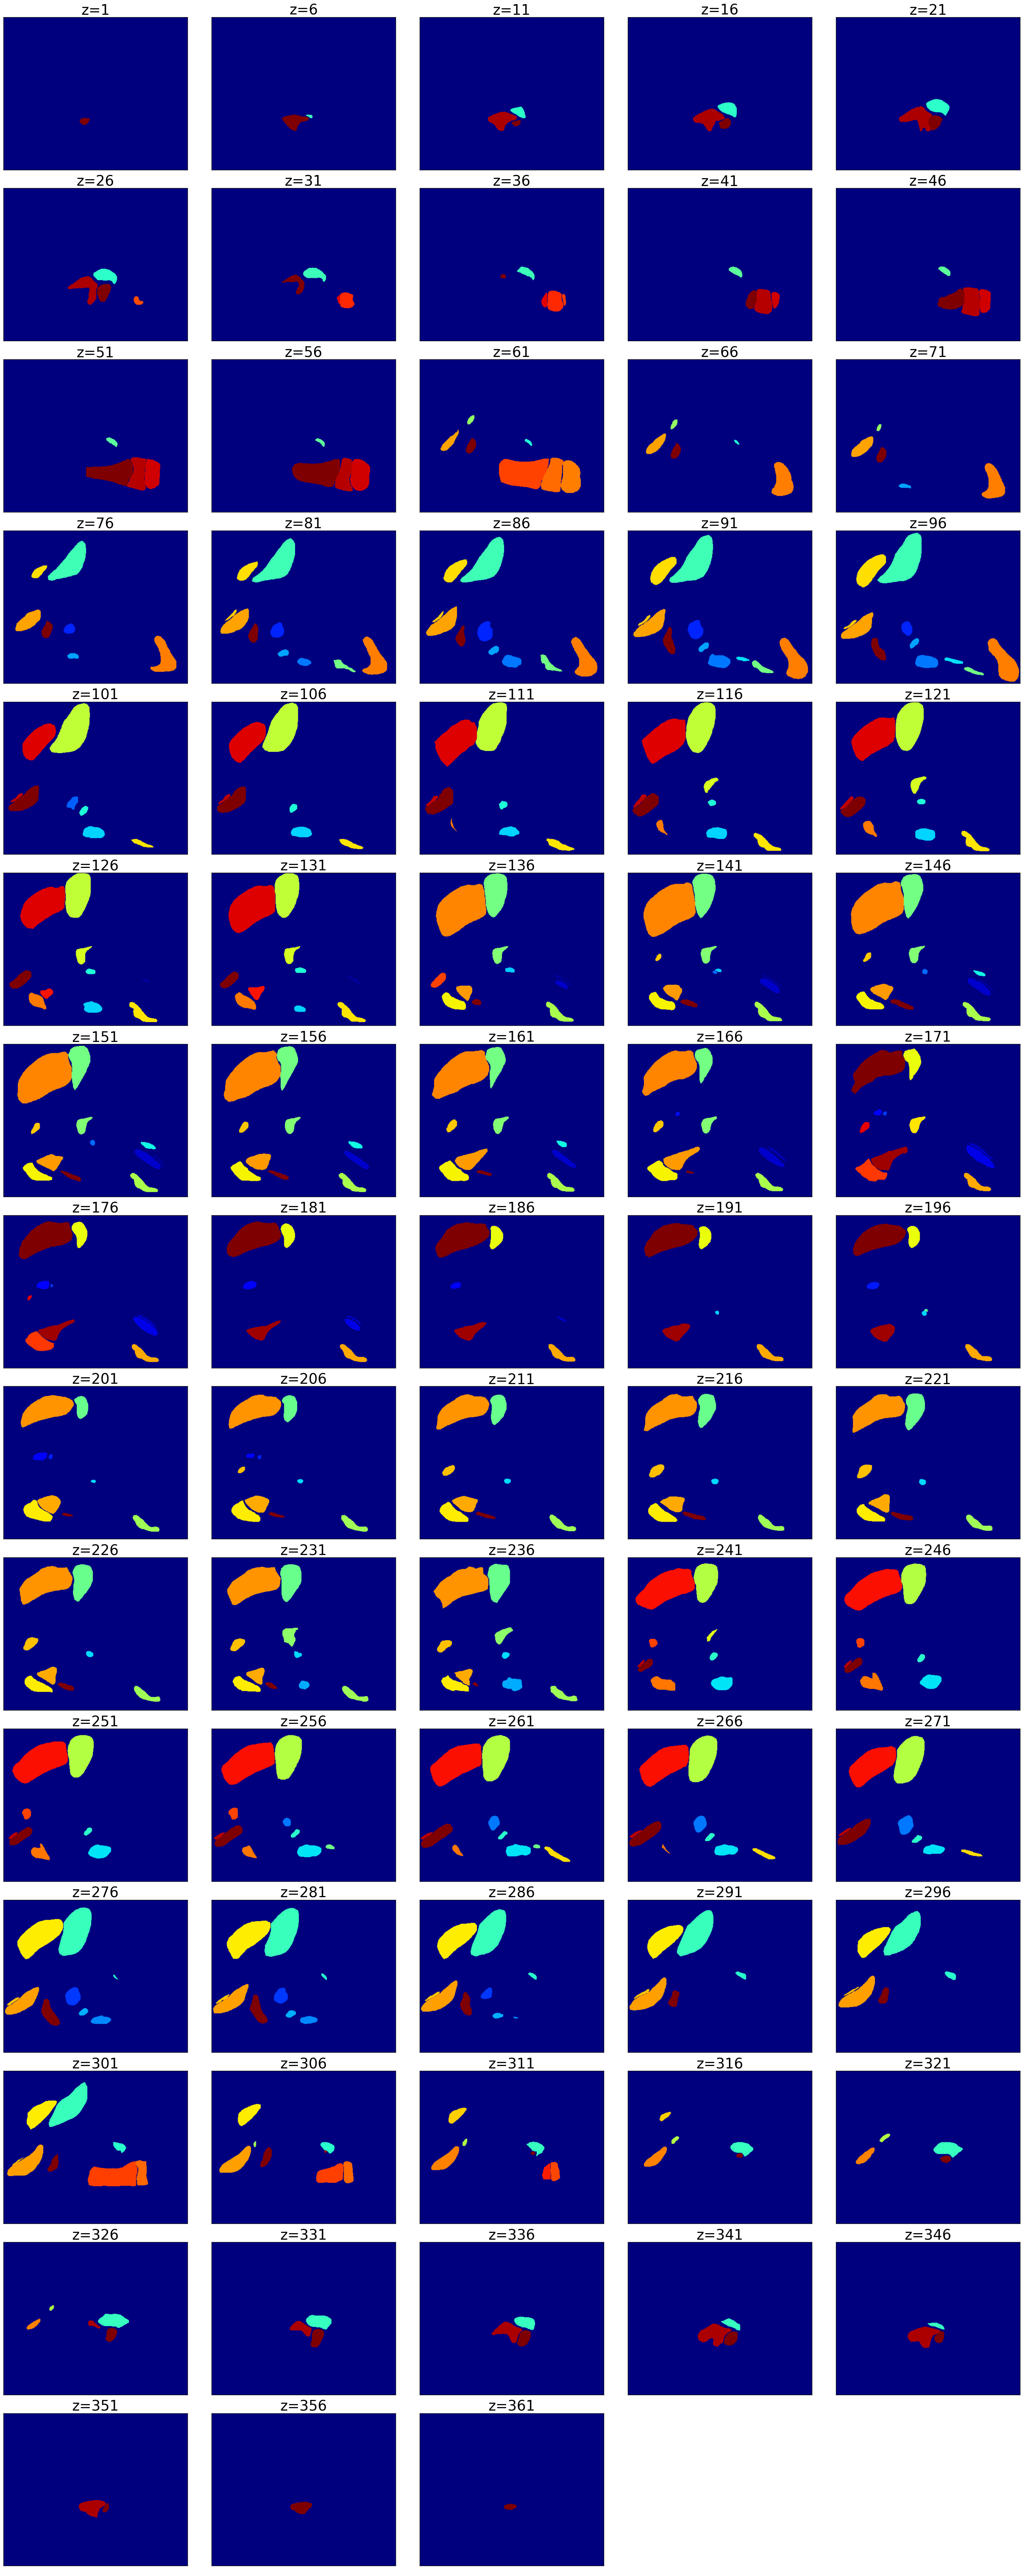

In [15]:
display_volume_sections(volume)

# Output


In [19]:
vol_fp = DataManager.get_annotation_volume_filepath(stack=stack, downscale=downscale)
create_parent_dir_if_not_exists(vol_fp)
bp.pack_ndarray_file(volume, vol_fp)

In [20]:
bbox_fp = DataManager.get_annotation_volume_bbox_filepath(stack=stack, downscale=downscale)
np.savetxt(bbox_fp, np.array(bbox)[None], fmt='%d')

In [21]:
name_label_map_fp = DataManager.get_volume_label_to_name_filepath(stack=stack)

with open(name_label_map_fp, 'w') as f:
    for structure, label in sorted(structure_to_label.items()):
        f.write(structure + ' ' + str(label) + '\n')

In [34]:
# with open(os.path.join(volume_dir, '%(stack)s/%(stack)s_down%(down)d_annotationVolume_landmarkBboxes.txt' % \
#                        dict(down=downsample_factor, stack=stack)), 'w') as f:
#     for name_s, label in sorted(name_s_to_label.items()):
#         bbox = bbox_3d(volume == label)
#         f.write(name_s + ' ' + ' '.join(map(str, bbox)) + '\n')

# Decompose as different volumes

In [47]:
volume = DataManager.load_annotation_volume(stack=stack, downscale=32)

print volume.shape

label_to_structure, structure_to_label = DataManager.load_volume_label_to_name(stack=stack)

vol_fixed_xmin, vol_fixed_xmax, vol_fixed_ymin, vol_fixed_ymax, vol_fixed_zmin, vol_fixed_zmax = \
DataManager.load_volume_bbox(stack=stack, type='annotation', downscale=32)

volume_decomposed = annotation_volume_to_score_volume(volume, label_to_structure)

for structure, v in volume_decomposed.iteritems():
    fp = DataManager.get_score_volume_filepath(stack=stack, downscale=32, structure=structure, volume_type='annotation_as_score')
    create_parent_dir_if_not_exists(fp)
    bp.pack_ndarray_file(v, fp)

(361, 435, 364)
